In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ssl
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere
from dipy.direction import DeterministicMaximumDirectionGetter
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
from dipy.io.streamline import save_trk
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response_ssst)
from dipy.reconst.dti import fractional_anisotropy, TensorModel
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import (ActStoppingCriterion,
                                              BinaryStoppingCriterion,
                                              ThresholdStoppingCriterion)
from dipy.viz import window, actor, colormap, has_fury

# Enables/disables interactive visualization
interactive = False

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')
_, _, f_pve_wm = get_fnames('stanford_pve_maps')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

white_matter = load_nifti_data(f_pve_wm)

seed_mask = (labels == 2)
seed_mask[white_matter < 0.5] = 0
seeds = utils.seeds_from_mask(seed_mask, affine, density=2)

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
csd_fit = csd_model.fit(data, mask=white_matter)

dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                      max_angle=30.,
                                                      sphere=default_sphere)

  0%|          | 0/5578 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/4 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/7 [00:00<?, ? MB/s]

  0%|          | 0/12 [00:00<?, ? MB/s]

  0%|          | 0/8 [00:00<?, ? MB/s]

In [3]:
tensor_model = TensorModel(gtab)
tenfit = tensor_model.fit(data, mask=labels > 0)
FA = fractional_anisotropy(tenfit.evals)

threshold_criterion = ThresholdStoppingCriterion(FA, .2)

In [4]:
streamline_generator = LocalTracking(dg,
                                     threshold_criterion,
                                     seeds,
                                     affine,
                                     step_size=1,
                                     return_all=True)
streamlines = Streamlines(streamline_generator)

In [5]:
streamlines

ArraySequence([array([[ -5.46250142, -38.75908845,   5.41959979],
       [ -4.5       , -38.5       ,   5.5       ],
       [ -3.53749858, -38.24091155,   5.58040021],
       [ -2.57499716, -37.98182311,   5.66080042],
       [ -1.58800768, -37.85785566,   5.76319107],
       [ -0.60101821, -37.7338882 ,   5.86558171],
       [  0.39816967, -37.69533075,   5.85388116]]), array([[ -4.46250142, -38.75908845,   5.41959979],
       [ -3.5       , -38.5       ,   5.5       ],
       [ -2.53749858, -38.24091155,   5.58040021],
       [ -1.5505091 , -38.1169441 ,   5.68279085],
       [ -0.56351963, -37.99297665,   5.7851815 ],
       [  0.43566825, -37.9544192 ,   5.77348095]]), array([[-27.99553184, -46.37492397,   1.39705033],
       [-27.19459016, -45.84251797,   1.67097783],
       [-26.38618245, -45.27103484,   1.81198852],
       [-25.58524077, -44.73862884,   2.08591602],
       [-24.78429909, -44.20622284,   2.35984352],
       [-23.98335741, -43.67381684,   2.63377101],
       [-23.

In [6]:
print(threshold_criterion.get())

AttributeError: 'dipy.tracking.stopping_criterion.ThresholdStopping' object has no attribute 'get'

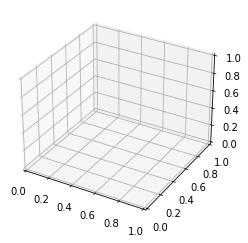

In [7]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

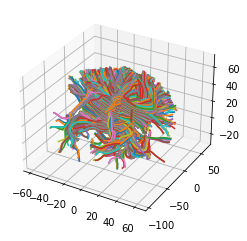

In [10]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')
for stream in streamlines:
    x,y,z=get_points(stream)
    ax.plot(x,y,z)
plt.show()

In [11]:
type(streamlines)

nibabel.streamlines.array_sequence.ArraySequence

In [12]:
def get_points(array):
    x=[]
    y=[]
    z=[]
    for i in array:
        x.append(i[0])
        y.append(i[1])
        z.append(i[2])
    return np.array(x),np.array(y),np.array(z)

In [13]:
from nibabel.streamlines import ArraySequence

In [14]:
def get_max_point_and_min_point(streamlines):
    max_x=0
    max_y=0
    max_z=0
    min_x=0
    min_y=0
    min_z=0
    for stream in streamlines:
        for point in stream:
            if(point[0]>max_x):
                max_x=point[0]
            if(point[1]>max_y):
                max_y=point[1]
            if(point[2]>max_z):
                max_z=point[2]
            if(point[0]<min_x):
                min_x=point[0]
            if(point[1]<min_y):
                min_y=point[1]
            if(point[0]<min_z):
                min_z=point[2]
    return ([max_x,max_y,max_z],[min_x,min_y,min_z])

In [15]:
point=get_max_point_and_min_point(streamlines)

In [16]:
point

([63.348167134274945, 67.03252137489085, 72.47387382009939],
 [-58.973879111728664, -96.10674051159612, 25.287098523554178])

In [17]:
def sum_array_in_matrix(array, sum_array):
    new_array=np.zeros_like(array)
    for i in range(array.shape[0]):
        new_array[i,:]=array[i,:]+sum_array
    return new_array

        

In [18]:
def normalize_streamlines(streamlines,sum_array):
    new_streamlines=ArraySequence()
    for stream in streamlines:
        new_streamlines.append(sum_array_in_matrix(stream,sum_array).astype(int))
    return new_streamlines
    

In [19]:
new=normalize_streamlines(streamlines,np.array([58.973879111728664, 96.10674051159612, 25.287098523554178]))

In [20]:
new

ArraySequence([array([[53, 57, 30],
       [54, 57, 30],
       [55, 57, 30],
       [56, 58, 30],
       [57, 58, 31],
       [58, 58, 31],
       [59, 58, 31]]), array([[54, 57, 30],
       [55, 57, 30],
       [56, 57, 30],
       [57, 57, 30],
       [58, 58, 31],
       [59, 58, 31]]), array([[30, 49, 26],
       [31, 50, 26],
       [32, 50, 27],
       [33, 51, 27],
       [34, 51, 27],
       [34, 52, 27],
       [35, 52, 28],
       [36, 53, 28],
       [37, 53, 29],
       [37, 54, 29],
       [38, 54, 30],
       [39, 54, 31],
       [40, 55, 31],
       [41, 55, 31],
       [41, 56, 31],
       [42, 56, 31],
       [43, 56, 31],
       [44, 57, 31],
       [45, 57, 31],
       [46, 57, 30],
       [47, 57, 30],
       [48, 57, 30],
       [49, 57, 30],
       [50, 57, 30],
       [51, 58, 30],
       [52, 58, 30],
       [53, 58, 30],
       [54, 58, 30],
       [55, 58, 30],
       [56, 59, 30],
       [57, 59, 31],
       [58, 59, 31],
       [59, 59, 31]]), ..., array([[

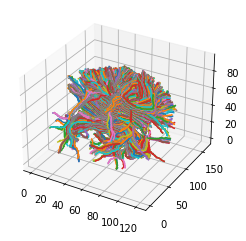

In [21]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')
for stream in new:
    x,y,z=get_points(stream)
    ax.plot(x,y,z)
plt.show()

In [22]:
point=get_max_point_and_min_point(new)

In [23]:
point

([122, 163, 97], [0, 0, 0])

In [ ]:

import nibabel as nib

ni_img = nib.Nifti1Image(data, affine=np.eye(4))
nib.save(ni_img, "dicom_volume_image.nii")

In [ ]:
new_matrix = np.zeros(shape=(123, 164, 98),dtype="float")

In [ ]:
import random

for stream in new:
    for point in stream:
        new_matrix[tuple(point)]=random.uniform(1, 2)
    
    

In [ ]:
for stream in new:
    for point in stream:
        print(new_matrix[tuple(point)])

In [ ]:
random.uniform(1, 2)

In [ ]:
new_matrix

In [ ]:
import nibabel as nib

ni_img = nib.Nifti1Image(new_matrix, affine=np.eye(4))
nib.save(ni_img, "dicom_volume_image_nuevo.nii")